In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from dython.nominal import associations
from sklearn.preprocessing import QuantileTransformer

df = pd.read_csv("transformed_data.csv", header=0).drop(columns=["accident_index_2"])

In [285]:
# looking for values that should be classed as missing
for i in zip(df.columns, df.dtypes):
    if i[1] == 'object':
        print(i[0], ":\n ", df[i[0]].unique(), "\n")

date.x :
  ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20'
 '2022-01-21' '2022-01-22' '2022-01-23' '2022-01-24' '2022-01-25'
 '2022-01-26' '2022-01-27' '2022-01-28' '2022-01-29' '2022-01-30'
 '2022-01-31' '2022-02-01' '2022-02-02' '2022-02-03' '2022-02-04'
 '2022-02-05' '2022-02-06' '2022-02-07' '2022-02-08' '2022-02-09'
 '2022-02-10' '2022-02-11' '2022-02-12' '2022-02-13' '2022-02-14'
 '2022-02-15' '2022-02-16' '2022-02-17' '2022-02-18' '2022-02-19'
 '2022-02-20' '2022-02-21' '2022-02-22' '2022-02-23' '2022-02-24'
 '2022-02-25' '2022-02-26' '2022-02-27' '2022-02-28' '2022-03-01'
 '2022-03-02' '2022-03-03' '2022-03-04' '2022-03-05' '2022-03-06'
 '2022-03-07' '2022-03-08' '2022-03-09' '2022-03-10' '2022-03-11'
 '2022-03-12' '2022-03-13' '2022-03-14' '2022-03-15' '2022-03-16'

In [286]:
# standardise missing values
missing_values = ['Data missing or out of range', 'unknown (self reported)', np.nan, 'Unknown', 'Not known', 'Undefined']
df = df.replace({i: "Missing" for i in missing_values})

In [287]:
# column summaries
pd.DataFrame([i for i in zip(df.columns, df.dtypes, df.nunique(), ((df == "Missing") | (df.isnull())).sum(), 100 * ((df == "Missing") | (df.isnull())).mean())], columns=['column', 'dtype', 'nunique', 'missing', 'missing %'])

,column,dtype,nunique,missing,missing %
0,longitude.x,float64,6353,0,0.000000
1,latitude.x,float64,6309,0,0.000000
2,date.x,object,365,0,0.000000
3,day_of_week,object,7,0,0.000000
4,time,object,1055,0,0.000000
5,first_road_class,object,4,0,0.000000
6,road_type,object,6,430,6.573918
7,speed_limit,int64,6,0,0.000000
8,junction_detail,object,10,338,5.167406
9,junction_control,object,5,1606,24.552821


In [288]:
# drop lsoa variables - too many unique values
# keep longitude, latitude, date as I may use these in future to join to extra data, but do not use in model
# remove age band variables and keep age variables
# remove variables with a high % missing - special_conditions_at_site, carriageway_hazards, skidding_and_overturning, hit_object_in_carriageway, hit_object_off_carriageway, journey_purpose_of_driver
# (skidding_and_overturning, hit_object_in_carriageway, hit_object_off_carriageway are also variables that would only be known after the collision occurred - so would not be fair to include in the model)
# remove vehicle_leaving_carriageway for same reason above
df = df.drop(columns=[
    'lsoa_of_casualty', 'lsoa_of_driver', 
    'age_band_of_casualty', 'age_band_of_driver',
    'special_conditions_at_site', 'carriageway_hazards', 'skidding_and_overturning', 'hit_object_in_carriageway', 'hit_object_off_carriageway', 'journey_purpose_of_driver', 'vehicle_leaving_carriageway'
])

# categorise speed_limit
df['speed_limit'] = df['speed_limit'].astype('object')

# convert numeric to continuous
df[['engine_capacity_cc', 'age_of_casualty', 'age_of_driver']] = df[['engine_capacity_cc', 'age_of_casualty', 'age_of_driver']].replace('Missing', np.nan).astype('float')

In [289]:
# check there are no duplicates
dups = df.duplicated()
dups.any()

True

In [290]:
# summary statistics of continuous variables
df.describe()

,longitude.x,latitude.x,RH2M,T2M,PRECTOTCORR,WS2M,age_of_casualty,engine_capacity_cc,age_of_vehicle,age_of_driver
count,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6541.000000,6298.000000,4242.000000,6541.000000,4324.000000
mean,-0.176117,51.498059,80.273594,12.428357,1.480294,3.149226,36.555891,1875.957331,4.724048,42.770583
std,0.210292,0.115428,10.775991,5.818082,3.188745,1.348237,14.509375,1293.098265,5.825349,15.189408
min,-0.997963,51.005849,45.940000,-2.700000,0.000000,0.650000,0.000000,108.000000,-1.000000,11.000000
25%,-0.230633,51.456590,73.000000,8.230000,0.030000,2.200000,26.000000,1390.000000,-1.000000,31.000000
50%,-0.130142,51.503308,79.250000,12.600000,0.220000,2.980000,34.000000,1598.000000,4.000000,41.000000
75%,-0.070124,51.541154,89.810000,16.800000,1.400000,3.920000,46.000000,1995.000000,8.000000,53.000000
max,0.398143,51.998495,99.000000,27.440000,31.110000,9.790000,94.000000,12902.000000,55.000000,95.000000


In [291]:
# age_of_vehicle has values of -1 -> these must be missing values
df['age_of_vehicle'] = df['age_of_vehicle'].replace(-1, np.nan)

### dealing with missing values

In [292]:
missing = pd.DataFrame([i for i in zip(df.columns, df.dtypes, df.nunique(), 100 * ((df == "Missing") | (df.isnull())).mean()) if i[3] > 0], columns=['column', 'dtype', 'nunique', 'missing %']).sort_values("missing %")
missing

,column,dtype,nunique,missing %
11,vehicle_type,object,19,0.045865
7,sex_of_casualty,object,3,1.788717
8,age_of_casualty,float64,93,3.715028
6,road_surface_conditions,object,6,3.867910
5,weather_conditions,object,9,4.081945
1,junction_detail,object,10,5.167406
0,road_type,object,6,6.573918
12,towing_and_articulation,object,6,7.460633
9,casualty_home_area_type,object,4,8.072160
10,casualty_imd_decile,object,11,8.439077


categorical variables

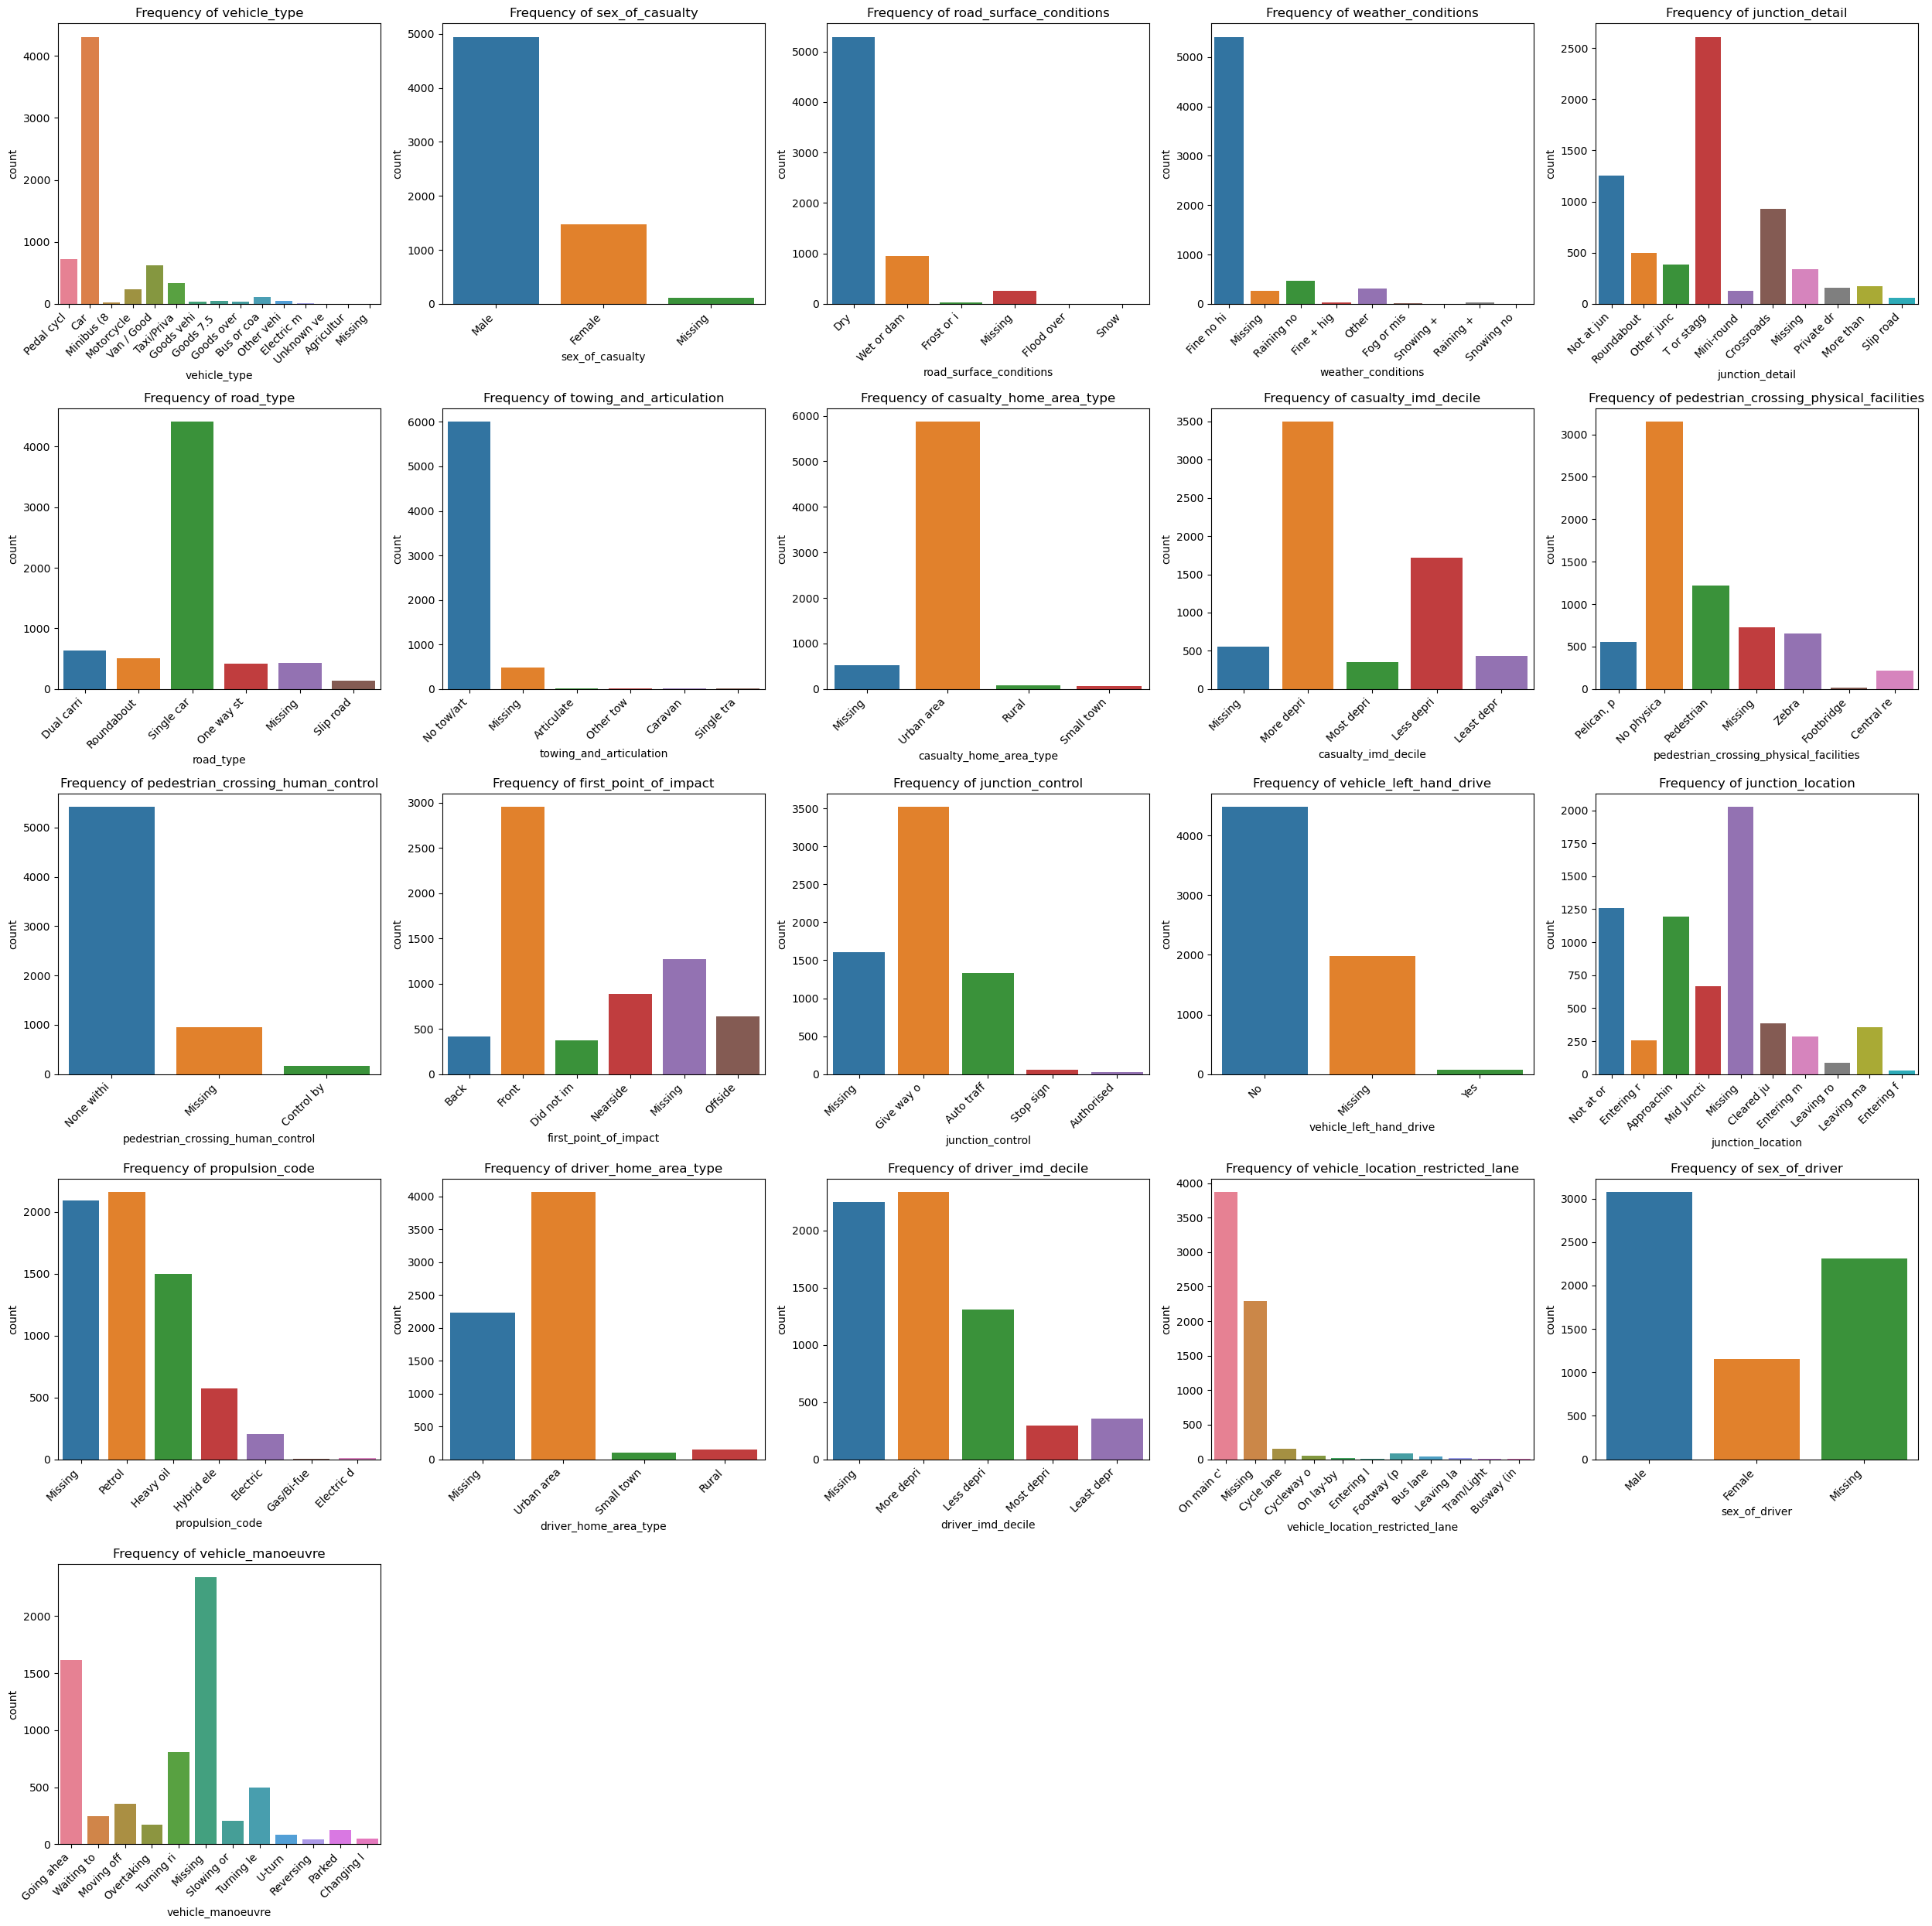

In [293]:
# viewing frequency distributions for categorical variables with missing values

# select only categorical columns
categorical_missing = list(missing[missing['dtype'] == 'object']['column'])

def plot_freq_dists(df):
    # calculate the number of rows and columns for a square layout
    num_vars = len(categorical_missing)
    cols = math.ceil(math.sqrt(num_vars))
    rows = math.ceil(num_vars / cols)

    # set up a grid of subplots
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows))
    ax = ax.flatten()

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:10] if isinstance(x, str) else x)

    # plot frequency distribution for each categorical column
    for i, col in enumerate(categorical_missing):
        sns.countplot(x=col, data=df_trimmed, ax=ax[i], hue=col, legend=False)
        ax[i].set_title(f'Frequency of {col}')
        ax[i].xaxis.set_ticks(ax[i].get_xticks()) # add this line to avoid warning
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
        
    # hide any unused subplots
    for i in range(num_vars, len(ax)):
        fig.delaxes(ax[i])

    plt.tight_layout()
    plt.show()

plot_freq_dists(df)

- for missing vars we can either simple impute or use a more sophisticated method such as kNN
- for categorical vars we can also just leave as a "Missing" category

The STATS19 data is completed by police at the scene of the incident, so I don't think the missing data is inherently meaningful* for most variables i.e. it seems unlikely that police are deliberately not filling in certain fields because they don't want to share the information. It seems more likely that they simply forgot to fill it in, didn't have enough time, couldn't be bothered, the data was corrupted, etc. However, missing data could still be correlated with the casualty severity - I can imagine that police might be more inclined to spend time filling in all the fields on the form if the collision is not very serious and they have time to spare, however if there's a fatality then filling out a long form might be less of a priority. Since my primary goal is to infer the risk factors for cycle collision severity, I don't want to include these missing categories if they have this 'fake' correlation with casualty severity. I will investigate this further by looking at the correlation of each of these variables with the target, using Cramer's V.

*Edit: After reading the guidance to police for filling in the STATS19 form, it does actually seem that missing data can have some meaning. For example, if the sex of the driver is missing then this is likely because there was a hit-and-run incident and so the driver could not be identified. I think this backs up my choice to not add "Missing" as a separate category, as a hit-and-run incident is not something that could be known before the collision.

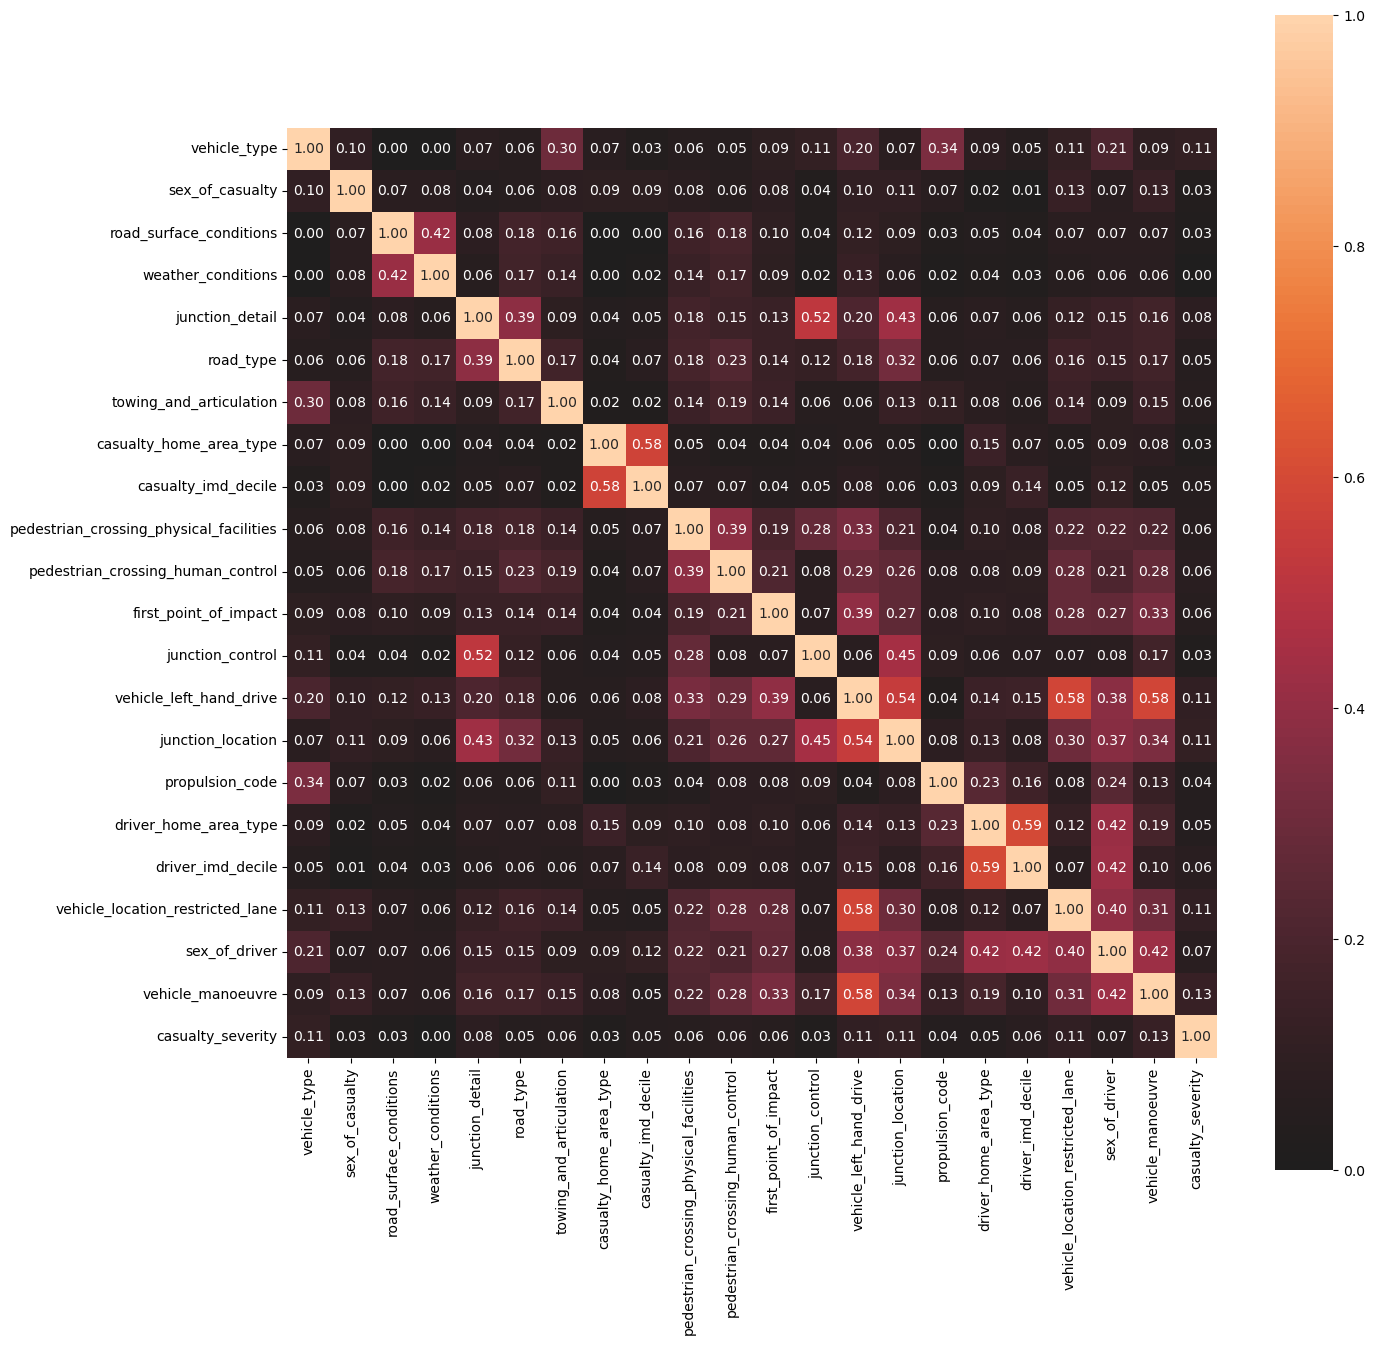

{'corr':                                          vehicle_type  sex_of_casualty  \
 vehicle_type                                 1.000000         0.103255   
 sex_of_casualty                              0.103255         1.000000   
 road_surface_conditions                      0.000000         0.073499   
 weather_conditions                           0.000000         0.075167   
 junction_detail                              0.071326         0.040140   
 road_type                                    0.062171         0.061512   
 towing_and_articulation                      0.304167         0.083921   
 casualty_home_area_type                      0.067608         0.088894   
 casualty_imd_decile                          0.032097         0.091458   
 pedestrian_crossing_physical_facilities      0.059830         0.077481   
 pedestrian_crossing_human_control            0.050238         0.062269   
 first_point_of_impact                        0.090738         0.082179   
 junction_control

In [294]:
associations(df[categorical_missing + ['casualty_severity']], nom_nom_assoc="cramer", figsize=(15, 15))

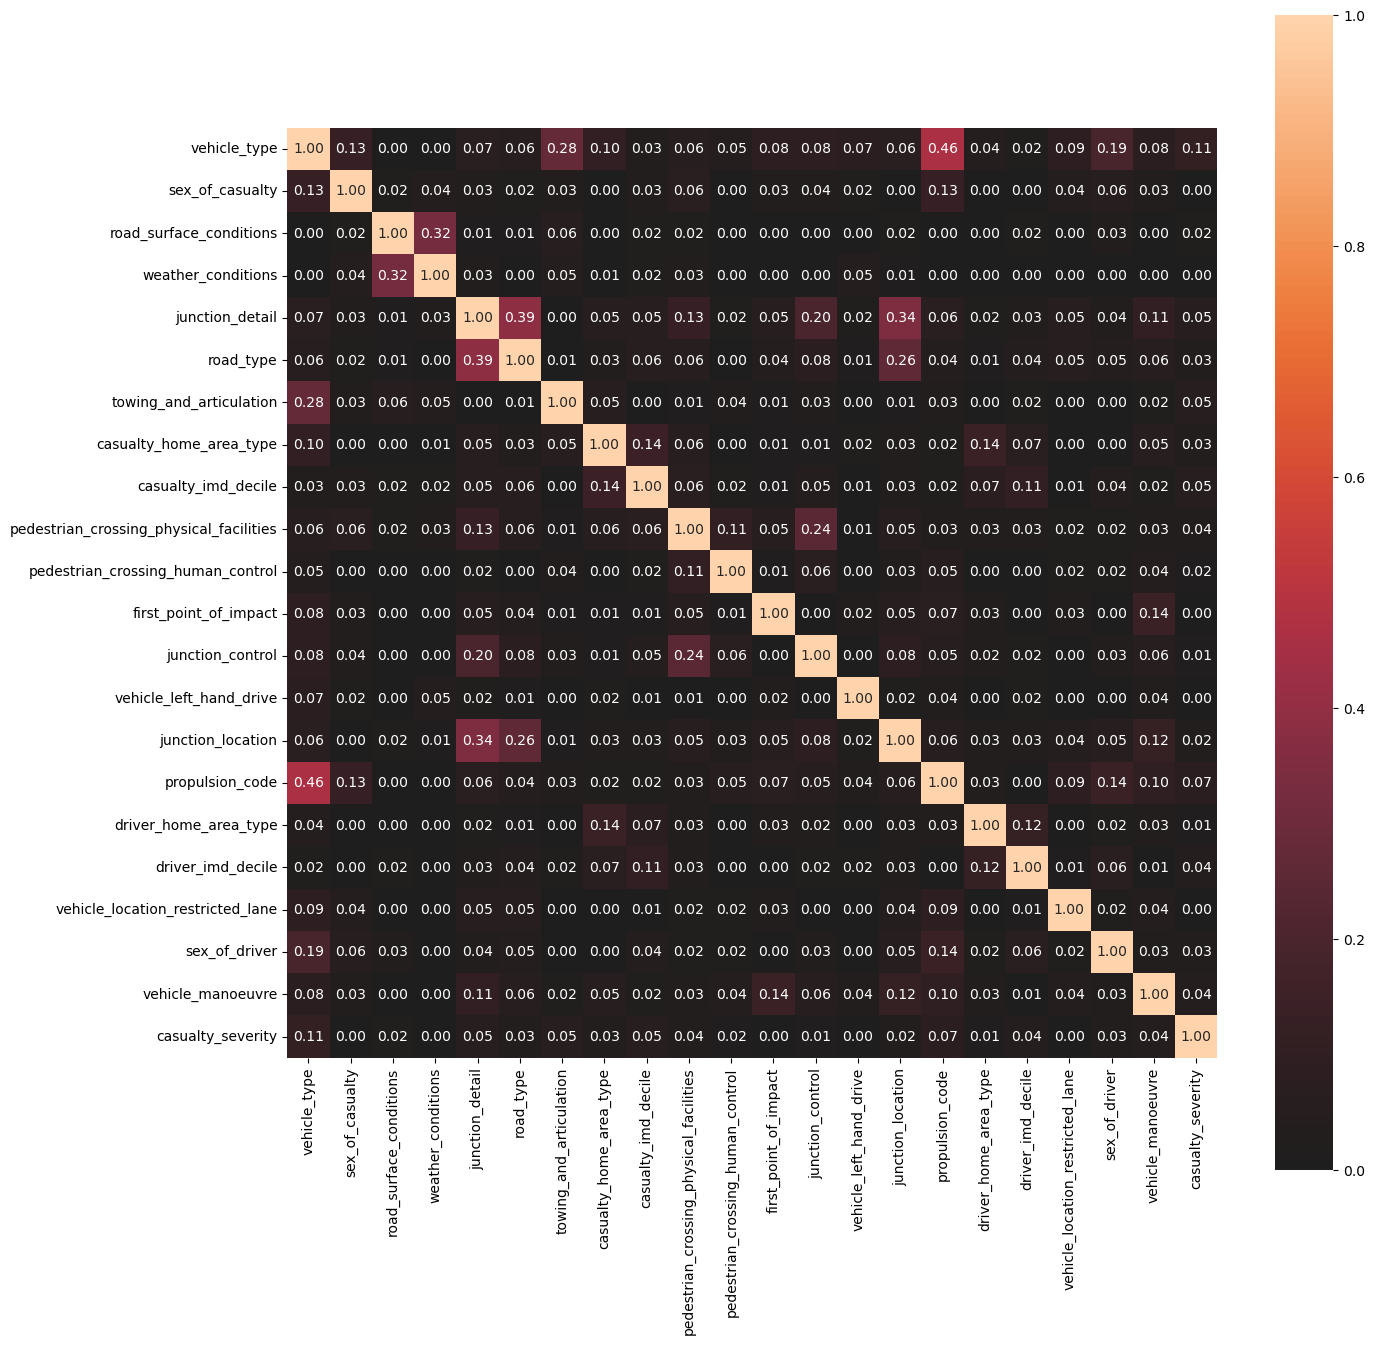

{'corr':                                          vehicle_type  sex_of_casualty  \
 vehicle_type                                 1.000000         0.129628   
 sex_of_casualty                              0.129628         1.000000   
 road_surface_conditions                      0.000000         0.021660   
 weather_conditions                           0.000000         0.043284   
 junction_detail                              0.068160         0.028336   
 road_type                                    0.056286         0.016037   
 towing_and_articulation                      0.278510         0.031351   
 casualty_home_area_type                      0.104161         0.000000   
 casualty_imd_decile                          0.028921         0.028027   
 pedestrian_crossing_physical_facilities      0.060268         0.064261   
 pedestrian_crossing_human_control            0.046318         0.000000   
 first_point_of_impact                        0.080932         0.031454   
 junction_control

In [295]:
# looking at associations again, but with missing values imputed while keeping the category distributions of each variable the same
df = df.replace("Missing", np.nan)

for col in categorical_missing:
    freq_dict = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].fillna(pd.Series(np.random.choice(list(freq_dict.keys()), p=list(freq_dict.values()), size=len(df))))

# does not make sense for propulsion_code to have a value for cyclists
df["propulsion_code"] = np.where(df["vehicle_type"] == "Pedal cycle", "Undefined", df["propulsion_code"])   

associations(df[categorical_missing + ['casualty_severity']], nom_nom_assoc="cramer", figsize=(15, 15))

Lots of variables are highly associated with each other in the 1st grid but not at all in the 2nd grid - showing that they are only associated because of the missing values. Clearly these fields are either mostly filled in or not filled in at all. For example, in the 1st grid vehicle_left_hand_drive is strongly associated with vehicle_manoeuvre and vehicle_location_restricted_lane - and vehicle_left_hand_drive is also associated with casualty_severity. I suspect that the vehicle_left_hand_drive field is only ever filled in if the driver was doing something dangerous, like a U-turn or sitting in a restricted lane, which would explain why vehicle_left_hand_drive is associated with casualty_severity when I wouldn't really expect it to be.

In the 2nd grid the associations make more sense e.g. road_type and junction_detail, propulsion_code and vehicle_type. However, very few of the variables are associated with casualty_severity so I am not sure how useful they will be for the model.

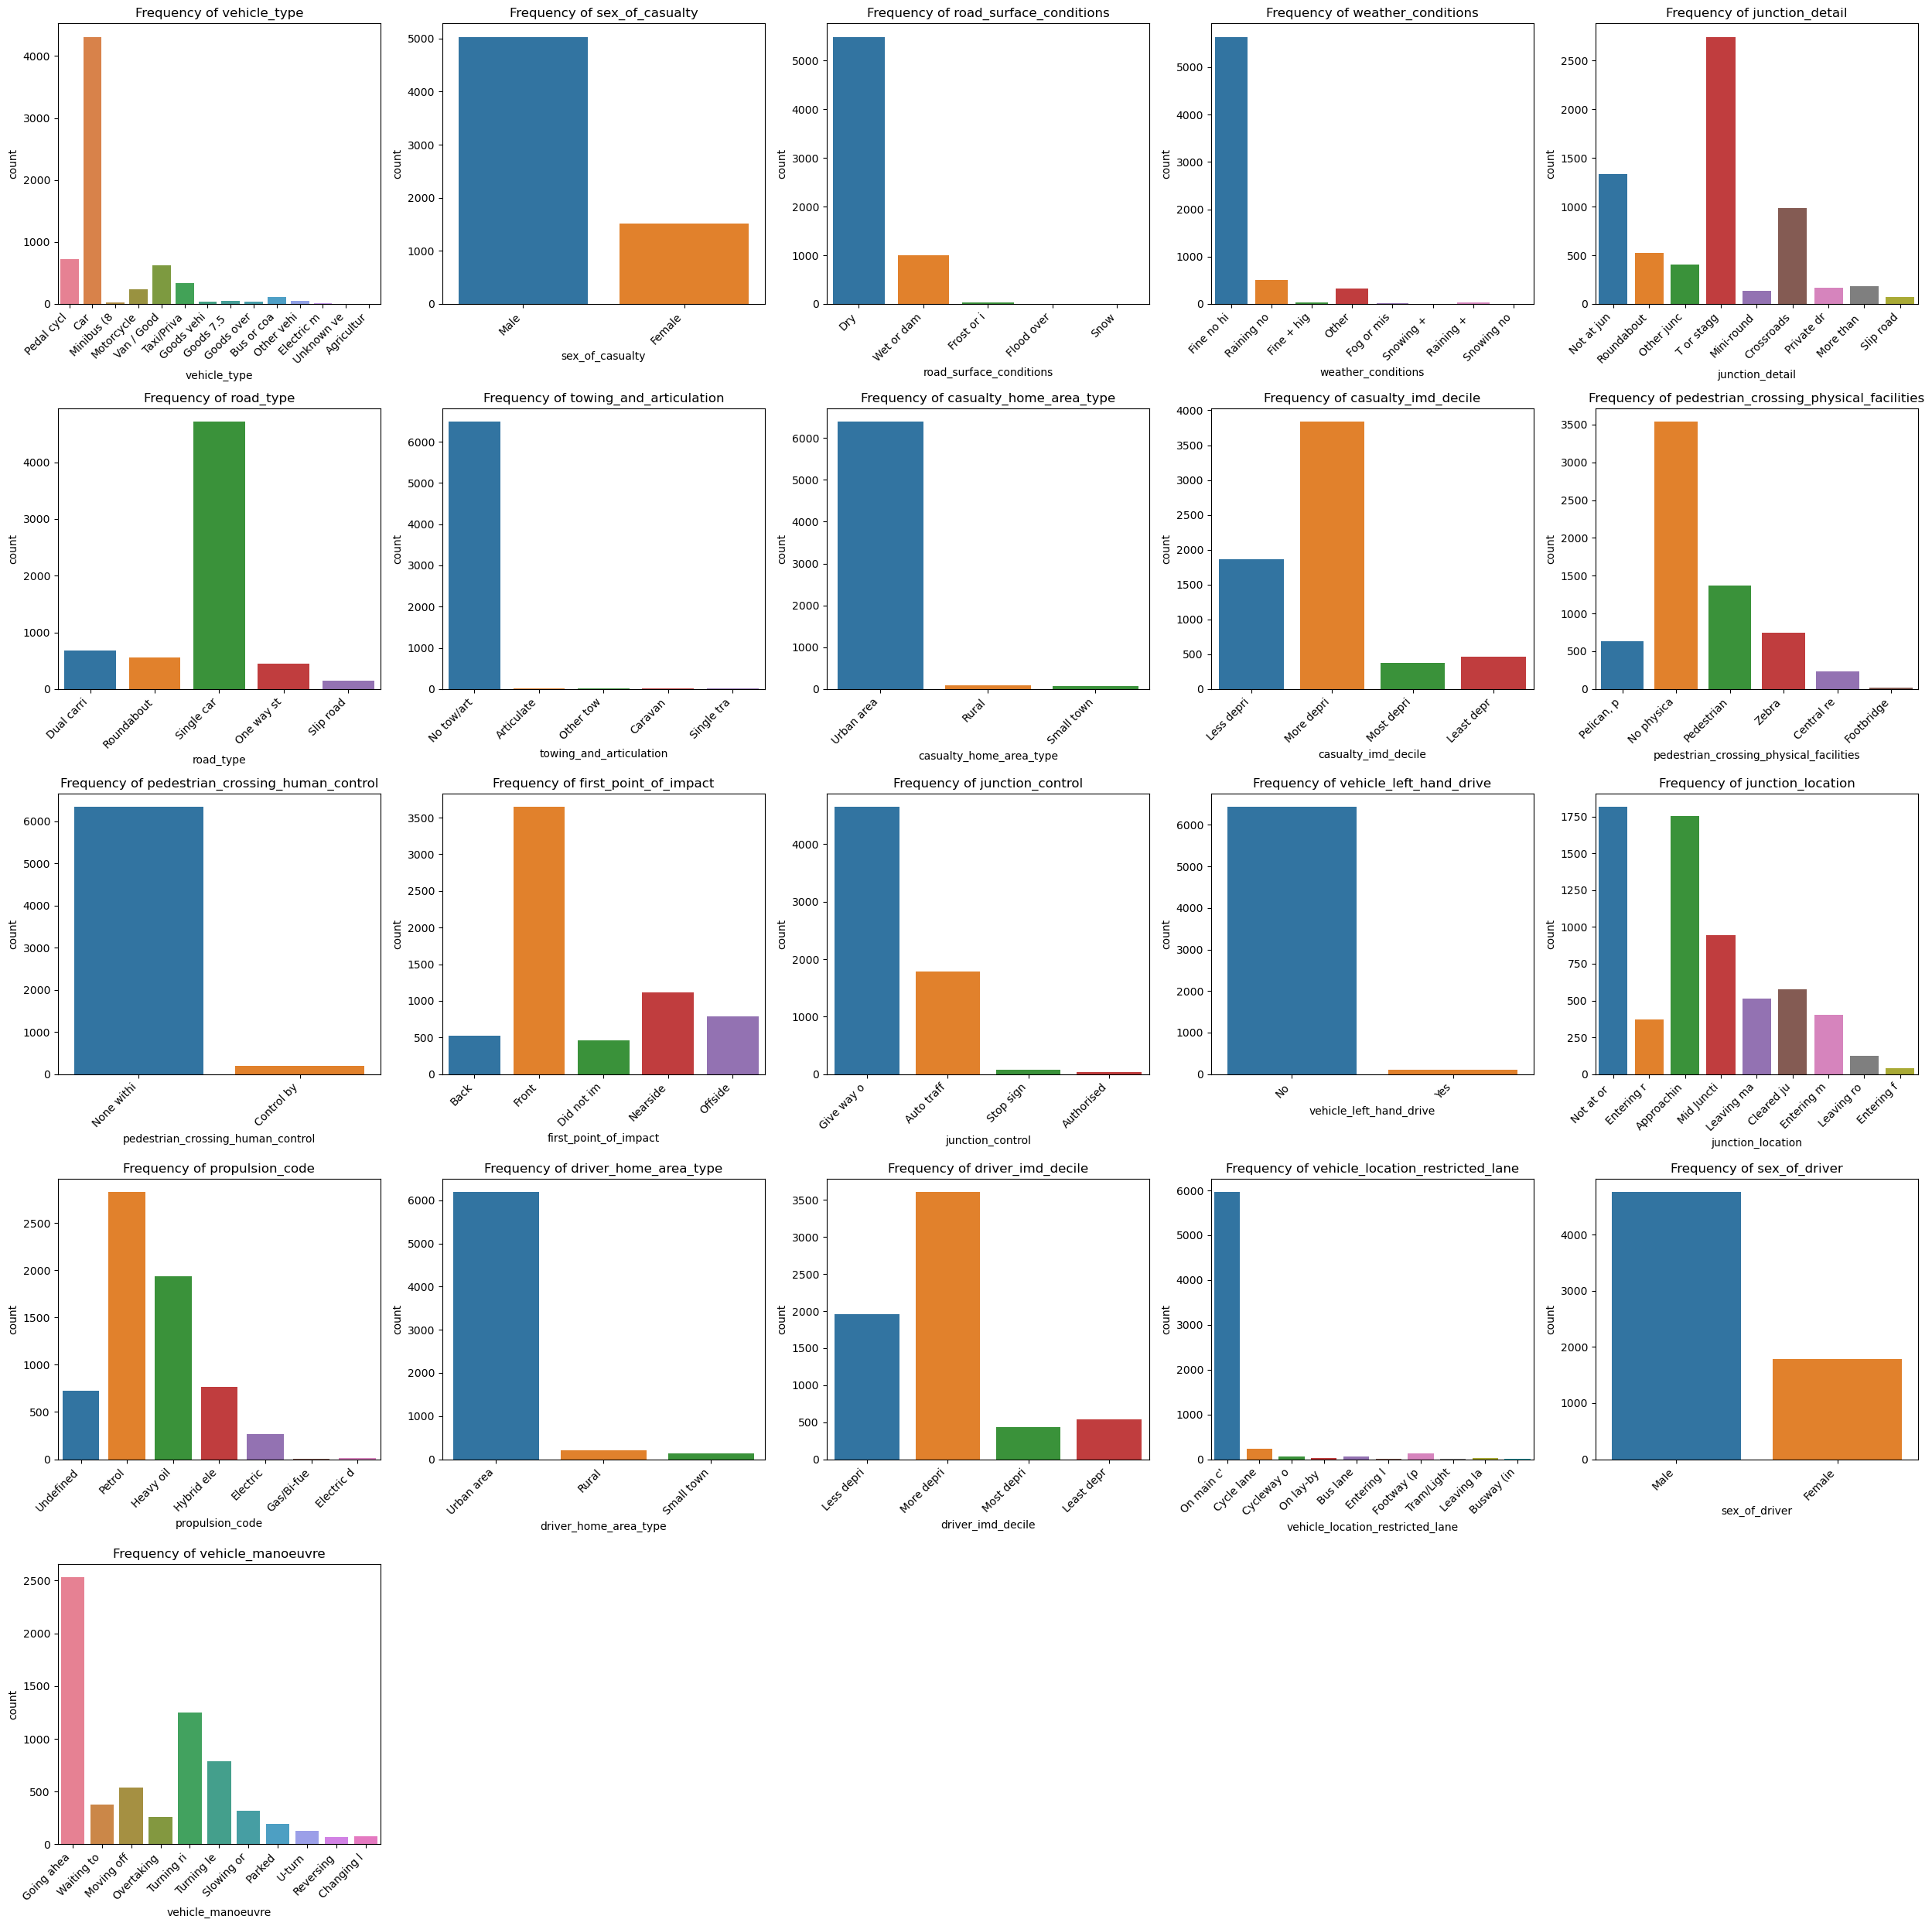

In [296]:
# plot frequency distributions with imputed missing values
plot_freq_dists(df)

continuous variables

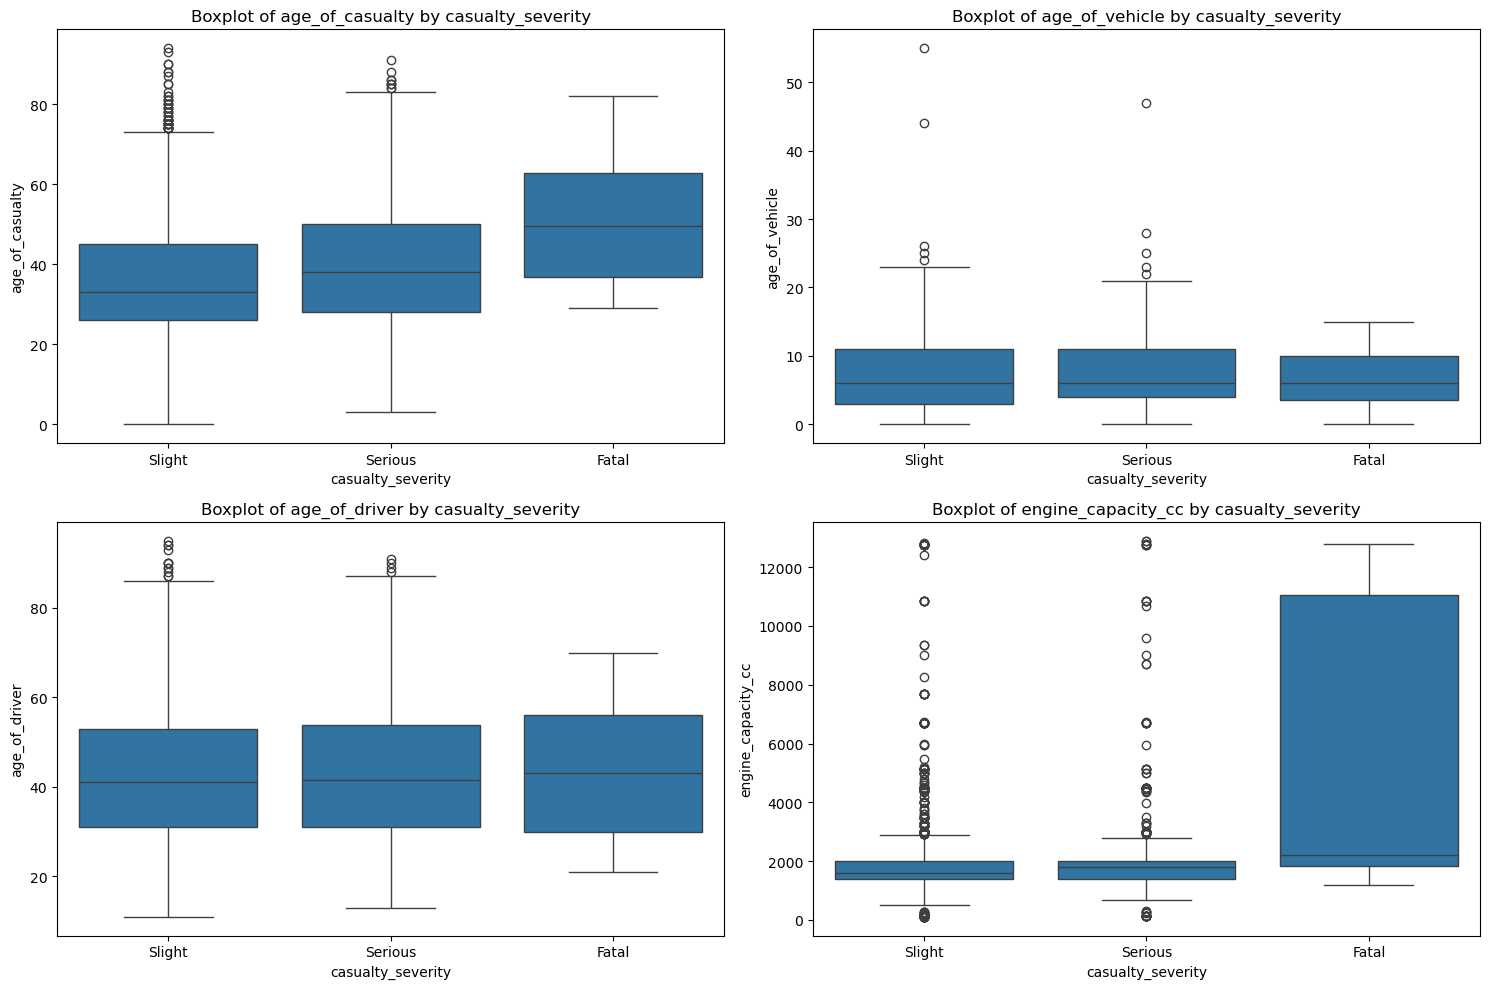

In [297]:
# plot box plots of each continous variable by target group

continuous_missing = list(missing[~(missing['dtype'] == 'object')]['column'])

def plot_continuous_missing(plot_type, vars, df):
    # set up the number of rows and columns for the grid
    num_vars = len(vars)
    num_cols = 2
    num_rows = (num_vars + num_cols - 1) // num_cols

    # create a figure and a grid of subplots
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    ax = ax.flatten()

    for i, var in enumerate(vars):
        if plot_type == "boxplot":
            sns.boxplot(x="casualty_severity", y=var, data=df, ax=ax[i])
            ax[i].set_title(f'Boxplot of {var} by {"casualty_severity"}')
            ax[i].set_xlabel("casualty_severity")
            ax[i].set_ylabel(var)
        elif plot_type == "kde":
            sns.histplot(df[var], kde=True, ax=ax[i])
            ax[i].set_title(f'Histogram & KDE of {var}')
            ax[i].set_xlabel(var)
            ax[i].set_ylabel('Density')

    # remove empty axes
    for i in range(num_vars, num_rows * num_cols):
        fig.delaxes(ax[i])

    plt.tight_layout()
    plt.show()

plot_continuous_missing("boxplot", continuous_missing, df)

- engine_capacity_cc is much higher for the fatal group - not surprising but didn't expect this trend to be so clear
- clear trend in increasing age_of_casualty with increasing casualty severity - I was expecting younger people to be more at risk for fatal accidents due to them taking more risks on the bike, however this is showing the opposite. Perhaps because older people are more likely to take a bad fall, or are less confident on the road
- age_of_vehicle distribution looks no different between the different groups, except for a slightly shorter right-hand tail in the fatal group - median looks almost exactly the same between groups. The fatal group is smaller so could just be that the outliers in vehicle age happen to be in the other groups
- age_of_driver distribution for the fatal group has larger IQR but smaller range - larger IQR makes sense as we typically think of young or elderly drivers as being more dangerous

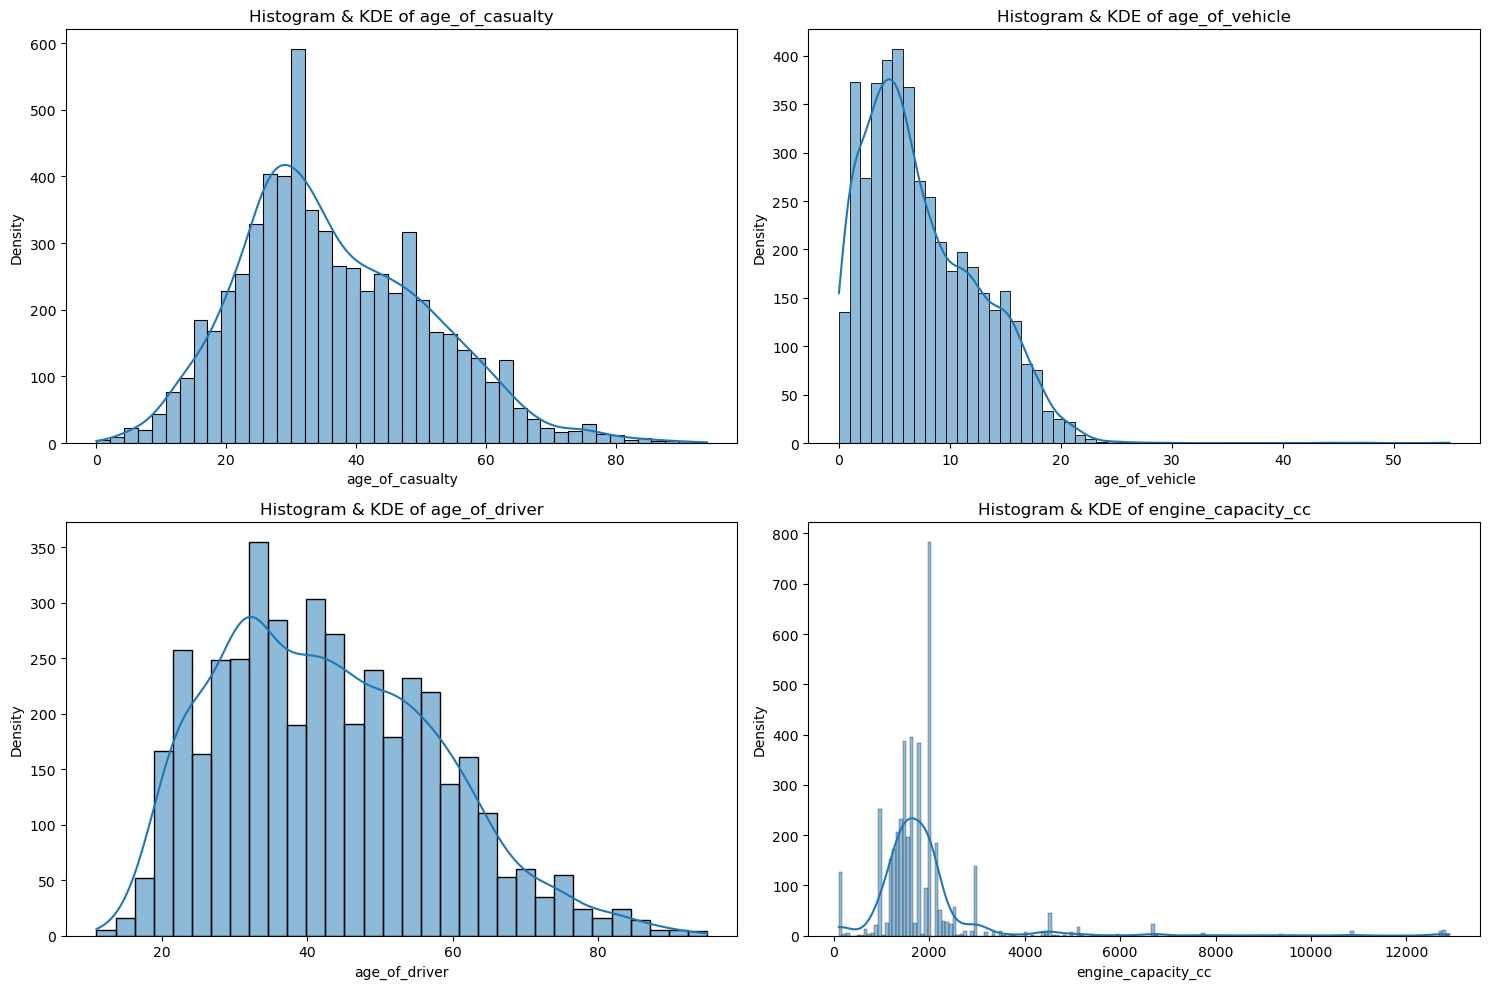

In [298]:
plot_continuous_missing("kde", continuous_missing, df)

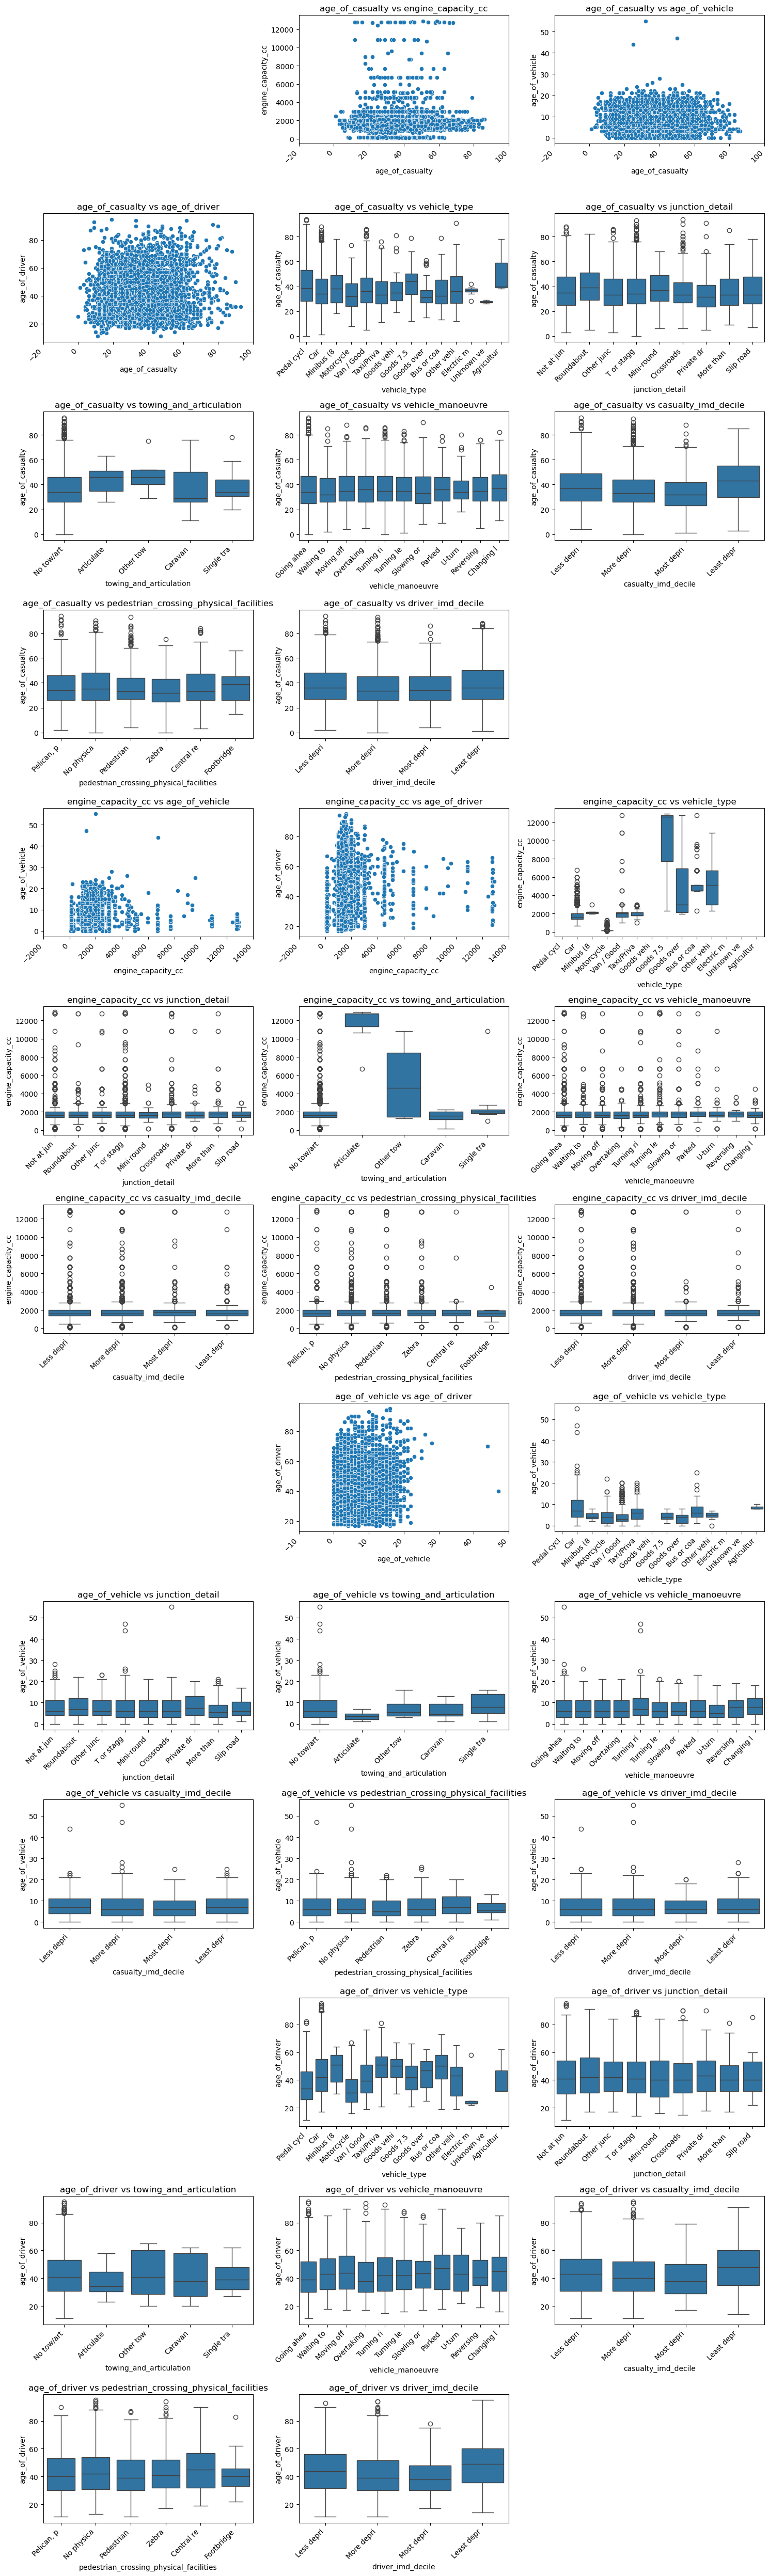

In [299]:
# plotting correlation between all continuous variables and useful categorical variables (based on association grid above)
# can use this to see if any variables will be useful for imputing the continuous variables with missing values

def is_continuous(series):
    return pd.api.types.is_numeric_dtype(series)

# function assumes that continuous variables are listed before categorical columns in the 'columns' input
def plot_correlation_grid(df, columns, num_cols=3):
    num_vars = len(columns)
    num_continuous_vars = sum([0 if i in df.select_dtypes(include='object').columns else 1 for i in columns])
    num_plots = sum([num_vars - i for i in range(num_continuous_vars)])
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 50))
    ax = ax.flatten()
    
    # get all pairs of variables to plot
    plotted_pairs = 0
    max_plots = num_rows * num_cols

    # axes to delete
    delete_axes = []

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:10] if isinstance(x, str) else x)
    
    for i, var1 in enumerate(columns):
        for j, var2 in enumerate(columns):
            if i <= j:  # only plot unique combinations
                ax_sub = ax[plotted_pairs]
                
                if var1 == var2: # skip if same variable
                    ax_sub.axis('off') 
                    delete_axes.append(plotted_pairs)
                else:
                    # if both variables are continuous, create a scatter plot
                    if is_continuous(df_trimmed[var1]) and is_continuous(df_trimmed[var2]):
                        sns.scatterplot(x=df_trimmed[var1], y=df_trimmed[var2], ax=ax_sub)
                    # if one variable is continuous and the other is categorical, create a box plot
                    elif is_continuous(df_trimmed[var1]) and not is_continuous(df_trimmed[var2]):
                        sns.boxplot(x=df_trimmed[var2], y=df_trimmed[var1], ax=ax_sub)
                    elif is_continuous(df_trimmed[var2]) and not is_continuous(df_trimmed[var1]):
                        sns.boxplot(x=df_trimmed[var1], y=df_trimmed[var2], ax=ax_sub)
                    # skip plots for two categorical variables
                    else:
                        ax_sub.axis('off')
                        delete_axes.append(plotted_pairs)

                ax_sub.set_title(f'{var1} vs {var2}')
                ax_sub.xaxis.set_ticks(ax_sub.get_xticks()) # add this line to avoid warning
                ax_sub.set_xticklabels(ax_sub.get_xticklabels(), rotation=45, ha='right')
                plotted_pairs += 1
                
                if plotted_pairs >= max_plots:
                    break
        if plotted_pairs >= max_plots:
            break

    # delete empty axes
    for i in delete_axes:
        fig.delaxes(ax[i])
    
    plt.tight_layout()
    plt.show()

plot_correlation_grid(df, ['age_of_casualty','engine_capacity_cc','age_of_vehicle','age_of_driver',
                           'vehicle_type','junction_detail','towing_and_articulation','vehicle_manoeuvre','casualty_imd_decile','pedestrian_crossing_physical_facilities','driver_imd_decile'])

- strong correlation between engine_capacity_cc and vehicle_type and towing_and_articulation
- some correlation between age_of_vehicle and vehicle_type and towing_and_articulation
- age_of_casualty and age_of_driver also correlate to some extent with vehicle_type -> cannot think of a reason why age_of_casualty would be correlated with vehicle_type, so will ignore this correlation

I will drop age_of_vehicle since it has little correlation with casualty_severity anyway.

Therefore, I will impute each continuous variable based on the categorical variables that they are correlated with (using the median value of the category).

I'm using the target variable casualty_severity to impute some of the variables, so will need to make sure I apply the imputation to the training and test data separately in order to prevent data leakage.

In [300]:
df = df.drop(columns=["age_of_vehicle"])

In [301]:
# creating new vehicle_type column because some values of vehicle_type have no values for engine_capacity_cc -> using other types of vehicle that have the most similar engine size
df["vehicle_type_2"] = [
    "Goods over 3.5t. and under 7.5t" if vehicle_type in ["Agricultural vehicle", "Goods vehicle - unknown weight"]
    else "Motorcycle 50cc and under" if vehicle_type == "Electric motorcycle"
    else "Motorcycle 125cc and under" if vehicle_type == "Motorcycle - unknown cc"
    else "Car" if vehicle_type == "Unknown vehicle type (self rep only)"
    else vehicle_type
    for vehicle_type in df["vehicle_type"]
]

# imputing continuous variables
# first imputation should capture most nulls
# second imputation should capture any remaining nulls (remaining because there were no values in the lookup group)
impute_dict_1 = {
    "engine_capacity_cc": ["vehicle_type_2"],
    "age_of_casualty": ["casualty_severity"],
    "age_of_driver": ["vehicle_type", "casualty_severity"]
}
impute_dict_2 = {
    "engine_capacity_cc": ["vehicle_type_2"],
    "age_of_casualty": ["casualty_severity"],
    "age_of_driver": ["casualty_severity"]
}

def impute_continuous_vars(df, impute_dict):
    for var in impute_dict:
        lookup_df = df.groupby(impute_dict[var])[var].median()
        df = pd.merge(df, lookup_df, how="left", on=impute_dict[var], suffixes=["", "_y"])
        df[var] = np.where(df[var].isna(), df[var + '_y'], df[var])
        df = df.drop(columns=[var + '_y'])

    return df

df_1 = impute_continuous_vars(df, impute_dict_1)
df_2 = impute_continuous_vars(df, impute_dict_2)
df = df_2

# "Pedal cycle" has no values for engine_capacity_cc for obvious reasons
# cyclist average ~0.25 horsepower -> average car ~200 horsepower -> cyclist horsepower 0.25/200=0.00125 of a car -> set engine_capacity_cc of "Pedal cycle" to 0.00125 that of a car
engine_capacity_car = df.groupby("vehicle_type")["engine_capacity_cc"].median().loc["Car"]
df["engine_capacity_cc"] = np.where(df["vehicle_type"] == "Pedal cycle", 0.00125 * engine_capacity_car, df["engine_capacity_cc"])

In [308]:
# check there are no more missing values
assert sum(((df.isna()) | (df == "Missing")).any()) == 0

### transforming variables

In [224]:
from sklearn.preprocessing import PowerTransformer

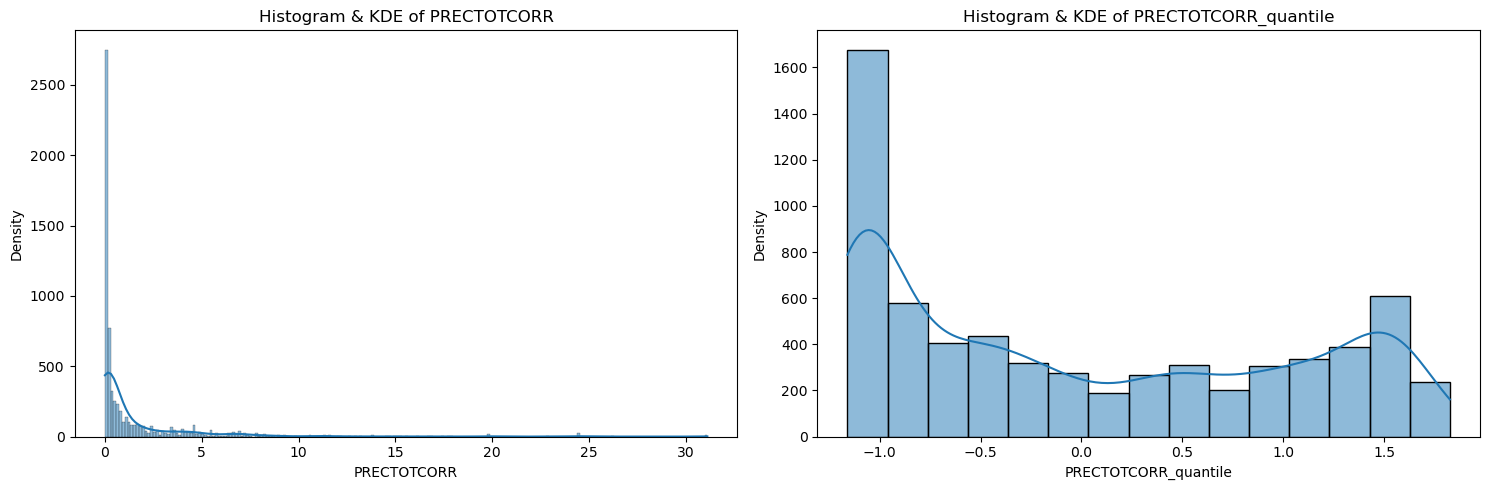

In [231]:
# transform continuous variables using quantile transform -> removes skew and standardises variable values
qt = QuantileTransformer(output_distribution='normal')
pt = PowerTransformer(method='yeo-johnson')

df["PRECTOTCORR_log"] = np.log1p(df["PRECTOTCORR"])
df["PRECTOTCORR_2"] = df["PRECTOTCORR"].clip(lower=1e-5)
df["PRECTOTCORR_2_log"] =  np.log(df["PRECTOTCORR_2"])

for col in ["PRECTOTCORR"]:#continuous_missing:
    if col == "PRECTOTCORR":
        transformed_col = pt.fit_transform(df[["PRECTOTCORR_log"]])
        df[col + '_quantile'] = transformed_col
    else:
        transformed_col = qt.fit_transform(df[[col]])
        df[col + '_quantile'] = transformed_col

#plot_continuous_missing("kde", [i + '_quantile' for i in continuous_missing])
plot_continuous_missing("kde", ["PRECTOTCORR", "PRECTOTCORR_quantile"], df)

In [145]:
df[df['age_of_vehicle_quantile'] < -4]['age_of_vehicle']

331     0.693147
502     0.693147
970     0.693147
989     0.693147
1089    0.693147
          ...   
6280    0.693147
6348    0.693147
6409    0.693147
6442    0.693147
6532    0.693147
Name: age_of_vehicle, Length: 135, dtype: float64

In [146]:
np.sort(np.exp(df['age_of_vehicle']).unique())

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 30., 46., 49., 57., nan])

In [189]:
np.sort(df['PRECTOTCORR'].unique())

array([0.000e+00, 1.000e-02, 2.000e-02, 3.000e-02, 4.000e-02, 5.000e-02,
       6.000e-02, 7.000e-02, 8.000e-02, 9.000e-02, 1.000e-01, 1.100e-01,
       1.200e-01, 1.300e-01, 1.400e-01, 1.500e-01, 1.600e-01, 1.700e-01,
       1.800e-01, 1.900e-01, 2.000e-01, 2.100e-01, 2.200e-01, 2.300e-01,
       2.400e-01, 2.500e-01, 2.600e-01, 2.700e-01, 2.800e-01, 2.900e-01,
       3.000e-01, 3.100e-01, 3.200e-01, 3.300e-01, 3.400e-01, 3.500e-01,
       3.600e-01, 3.700e-01, 3.800e-01, 3.900e-01, 4.000e-01, 4.100e-01,
       4.200e-01, 4.300e-01, 4.400e-01, 4.600e-01, 4.700e-01, 4.800e-01,
       4.900e-01, 5.000e-01, 5.100e-01, 5.200e-01, 5.300e-01, 5.400e-01,
       5.600e-01, 5.700e-01, 5.800e-01, 5.900e-01, 6.000e-01, 6.100e-01,
       6.200e-01, 6.300e-01, 6.400e-01, 6.500e-01, 6.600e-01, 6.700e-01,
       6.800e-01, 6.900e-01, 7.000e-01, 7.100e-01, 7.200e-01, 7.300e-01,
       7.400e-01, 7.500e-01, 7.600e-01, 7.700e-01, 7.800e-01, 7.900e-01,
       8.000e-01, 8.300e-01, 8.400e-01, 8.500e-01, 